# ATML - NLP
Authors:
- Elvi Mihai Sabau Sabau
- Pietro Miotto
- Yassine Oueslati
- Fabian Gobet

# Installs

In [1]:
!sudo apt update
!sudo apt install ffmpeg
!sudo apt-get install portaudio19-dev python-all-dev

Hit:1 https://download.docker.com/linux/ubuntu focal InRelease
Hit:2 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease 
Get:3 https://cli.github.com/packages stable InRelease [3917 B]                
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease                     
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease    
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Fetched 3917 B in 1s (6261 B/s)33m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
14 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not up

In [2]:
%pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install wandb langchain-community unstructured langchain-huggingface langchain-chroma unsloth datasets transformers trl scikit-learn nltk sentence-transformers evaluate bitsandbytes torch tqdm flask sounddevice SpeechRecognition scipy pydub wave gTTS simpleaudio plotly gensim


Note: you may need to restart the kernel to use updated packages.


# Imports and Configs

## Imports

In [5]:
from langchain_community.document_loaders import DirectoryLoader
from unstructured.partition.auto import partition
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document
from unsloth import FastLanguageModel, is_bfloat16_supported
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, TrainingArguments, DataCollatorForSeq2Seq
from trl import SFTTrainer
from torch import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score
from sentence_transformers import SentenceTransformer, util
from evaluate import load
from tqdm import tqdm
from flask import Flask, request, render_template_string, jsonify, send_file
from scipy.io.wavfile import write
from pydub import AudioSegment
from io import BytesIO
from contextlib import contextmanager
from werkzeug.serving import make_server
from gtts import gTTS
from collections import Counter
from sklearn.manifold import TSNE

import plotly.express as px
from datasets import Dataset, DatasetDict
import re
import spacy
import wave
import speech_recognition as sr
import socket
import sys
import time
import matplotlib.pyplot as plt
import numpy as np
import bitsandbytes
import shutil
import random
import pickle
import threading
import requests
import wandb
import torch
import os
import pandas as pd

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


## General Configs

In [6]:
# Paths
CHROMADB_PATH = 'chroma'
EVAL_RESULTS_PATH = 'eval_results'
LLM_DOWNLOAD_PATH = 'llm_downloaded_models'
LLM_FINTUN_CHECKPOINT_PATH = 'llm_finetuned_checkpoints'
LLM_FINTUNED_PATH = 'llm_finetuned_models'
DATA_ANALISYS = 'data_analisys'

# Dataset Used
DATASET = "medalpaca/medical_meadow_medical_flashcards"

# WandB Project
WANDB_PROJECT = "MEDICALPACA"

# Embeddings Model
EMBEDDINGS_MODEL = 'sentence-transformers/all-mpnet-base-v2' # Model name for the embeddings

# RAG parameters
CHROMA_COLLECTION_NAME = "Collection1" # Default collection ( database ) name for the Chroma database
EMBEDDINGS_THRESHOLD = 0.5 # Threshold for the embeddings to be considered relevant
EMBEDDINGS_TOP_K = 3 # Top K results to return from the Chroma database

# LLM Model ( Best models are Instruct with GGUF and 4b, check https://huggingface.co/collections/unsloth/4bit-instruct-models-6624b1c17fd76cbcf4d435c8 )
LLM_TASK = 'text-generation' # Task for the LLM: 'text-generation', 'question-answering', 'summarization'...
LLM_MAX_NEW_TOKENS = 100 # Maximum new number of tokens to generate
LLM_MAX_SEQ_LENGTH = 2048 # Maximum sequence length for the LLM
LLM_PADDING = 'max_length' # Padding for the LLM
LLM_RANDOM = False # Random generation for the LLM
LLM_TEMP = 0.1 # Temperature for the random generation
LLM_RETURN_FULL_TEXT = False # Add the system propmt to the returned text

# Prompt Template
PROMPT_INSTRUCTION = """
You are a precise and context-aware Q/A bot. Given the following documents, separated by lines:

------------------------------
{documents}

Analyze the question carefully and select the single document that best and most directly answers the question. 
Your reply must adhere to the following rules:

1. Provide EXACTLY and ONLY the content of the most relevant document, and NOTHING ELSE.
2. Do not include explanations, additional information, or any content outside of the selected document.

{question}

"""

## WandB

In [7]:
# Log both gradients and parameters
%env WANDB_WATCH=all
%env WANDB_PROJECT=$WANDB_PROJECT

env: WANDB_WATCH=all
env: WANDB_PROJECT=MEDICALPACA


In [8]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: frenzoid (frenzoid-atml). Use `wandb login --relogin` to force relogin


True

# Function Definitions

### Utils

In [9]:
# Show memory stats
def show_mem_stats():
    """ Show memory stats for the GPU """

    gpu_stats = torch.cuda.get_device_properties(0)
    start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
    
    print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
    print(f"{start_gpu_memory} GB of memory reserved.")

# Compress folder
def compress_folder(folder_path):
    """ Compress a folder into a zip file """
    # Get the folder name from the folder path
    folder_name = os.path.basename(os.path.normpath(folder_path))
    # Create the zip file with the same name as the folder
    shutil.make_archive(folder_name, 'zip', folder_path)

### Data Preprocess

In [10]:
def process_dataset_for_chroma(dataset):

    # Documents that will be added to the vectorial database
    documents = []

    for record in dataset:

        # Combine fields into a single text block
        text = f"Question: {record['input']}\nAnswer: {record['output']}"

        # Create a Document object with page_content and metadata
        document = Document(
            page_content=text, 
            metadata={
                "instruction": record['instruction'],
                "input": record['input'],
                "output": record['output']
            })


        # Append the Document object to the list
        documents.append(document)
        
    return documents

### Database Functions

In [11]:
# Initialize the database, either by loading an existing database or creating a new one.
def initialize_database(embeddings_model, documents):

    # If the database already exists, but we dont prelaod, then we delete it.
    if os.path.exists(CHROMADB_PATH):
        print(f"Deleting old database at path: {CHROMADB_PATH}")
        shutil.rmtree(CHROMADB_PATH)
    
    # Create a new database.
    print(f"Creating new database at path: {CHROMADB_PATH}, ( this will take a while )")
    return Chroma.from_documents(
        collection_name=CHROMA_COLLECTION_NAME, 
        documents=documents, 
        embedding=embeddings_model, 
        persist_directory=CHROMADB_PATH)


# Load the database if it already exists.
def load_database(embeddings_model):

    # If the database exists, load it.
    if os.path.exists(CHROMADB_PATH):
        print(f"Loading existing database from {CHROMADB_PATH}")
        return Chroma(
            collection_name=CHROMA_COLLECTION_NAME, 
            embedding_function=embeddings_model, 
            persist_directory=CHROMADB_PATH)
        
    # If the database does not exist, get angryyyyyyyyyyyyyyyyyy
    raise Exception("Database does not exist. If this is your first run, make sure CHROMA_LOAD is set to False in the ")


# Query the database with a given query.
def query_database(query, database):
    
    # Query the database with the given query and return the results.
    results = database.similarity_search_with_relevance_scores(query, k=EMBEDDINGS_TOP_K)
    return results

### LLM Handler

In [12]:
# Generate an answer using the huggingface pipeline.
def query_hf_pipeline(prompt, model, tokenizer):

    # Generace generator to easily interact with the LLM model
    generator = pipeline(
        task=LLM_TASK,
        model=model,
        tokenizer=tokenizer
    )

    # Pass generation arguments here
    output = generator(
        prompt,
        max_new_tokens=LLM_MAX_NEW_TOKENS,
        do_sample=LLM_RANDOM,
        temperature=LLM_TEMP,
        return_full_text=LLM_RETURN_FULL_TEXT
    )

    return output[0]['generated_text']


# Generate an answer using the classic method of using the model directly, same syntax also applies to huggingface models.
def query_unsloth(prompt, model, tokenizer):

    # Unsloth Specific: set model for inference
    FastLanguageModel.for_inference(model)

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate the output from the model
    output = model.generate(**inputs, 
        max_new_tokens=LLM_MAX_NEW_TOKENS,
        do_sample=LLM_RANDOM,
        temperature=LLM_TEMP)

    # Decode the output
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # get only the answer
    answer = remove_sysprompt(decoded_output, prompt)

    return answer


### Operator prompt generator

In [13]:
# Generate a RAG prompt for the LLM model using the query and the results from the database.
def generate_rag_sysprompt(relevant_chunks, query):
    
    # If there are no results, or the score of the results are below the threshold, tell the LLM to tell the user to try again.
    if not relevant_chunks or relevant_chunks[0][1] < EMBEDDINGS_THRESHOLD:
        return False

    # Generate a string with the documents and their scores.
    documents_str = "\n".join([f"{doc.page_content}\n------------------------------" for doc, _ in relevant_chunks])
    return PROMPT_INSTRUCTION.format(documents=documents_str, question=query)

    """
    You are a Q/A bot, and given the following documents:

    ------------------------------
    Question: What condition is suggested by the presence of tachycardia, tremors, and anxiety 2-4 days after surgery?
    Answer: The presence of tachycardia, tremors, and anxiety 2-4 days after surgery is suggestive of delirium tremens (DTs).
    ------------------------------
    Question: What condition is suggested by vital sign changes, tremors, and anxiety 2-4 days after surgery?
    Answer: Vital sign changes such as tachycardia (fast heart rate) and hypertension (high blood pressure), as well as tremors and anxiety, 2-4 days after surgery may be suggestive of delirium tremens (DTs). DTs is a severe form of alcohol withdrawal that can occur in individuals who have a history of heavy alcohol use and abruptly stop drinking. The symptoms of DTs can include confusion, disorientation, hallucinations, seizures, and autonomic instability, which can manifest as changes in vital signs such as heart rate and blood pressure. DTs is a medical emergency and requires immediate treatment, including supportive care, benzodiazepines, and in severe cases, antipsychotic medications. It is important for healthcare providers to be aware of the risk factors for DTs and to monitor patients closely for signs and symptoms of this condition, particularly in the postoperative period.
    ------------------------------
    Question: What are some factors that can cause postoperative arrhythmia following both cardiac and noncardiac surgery?
    Answer: Postoperative arrhythmia is a common complication of surgery, particularly cardiac surgery. However, noncardiac surgeries can also lead to arrhythmias. Several factors can contribute to the development of postoperative arrhythmia, including high levels of catecholamines, electrolyte imbalances, reduced ventilation, and certain drugs, such as thiazides. Catecholamines are hormones that are released in response to stress, and they can increase heart rate and blood pressure, which can lead to arrhythmias. Electrolyte imbalances, such as low potassium or magnesium levels, can also disrupt the normal electrical activity of the heart. Reduced ventilation or oxygen levels can also contribute to arrhythmias. Certain drugs, such as thiazides, can also affect electrolyte levels and increase the risk of arrhythmias. It is important to monitor patients closely for arrhythmias after surgery and to address any contributing factors promptly to minimize the risk of complications.
    ------------------------------

    Reply EXACTLY AND ONLY with the content of the document that best answers the question:

    What condition is suggested by the presence of tachycardia, tremors, and anxiety 2-4 days after surgery?
    """


# Generate the few-shot learning prompt for the LLM model.
def generate_fewshots_sysprompt(database):
    # Select random examples from the dataset
    random_examples = random.sample(list(zip(dataset['input'], dataset['output'])), 4)
    random_examples_formatted = [
        f"Input: {ex[0]}\nOutput: {ex[1]}\n\n"
        for ex in random_examples
    ]

    # Format the few-shot examples into a single string
    few_shot_prompt = "Given the following examples:\n\n"
    few_shot_prompt += "".join(random_examples_formatted)

    return few_shot_prompt

    """
    Given the following examples:

    Input: How do pancreatic pseudocysts typically appear on ultrasound?
    Output: On ultrasound, pancreatic pseudocysts typically appear as anechoic or hypoechoic collections.

    Input: What type of secretion system does Salmonella spp. contain and how does it act as a virulence factor?
    Output: Salmonella spp. contains a type III secretion system that acts as a virulence factor.

    Input: What is diffusion-limited gas exchange and what happens to the gas by the time blood reaches the end of the capillary?
    Output: In diffusion-limited gas exchange, the gas does not equilibrate by the time blood reaches the end of the capillary.

    Input: In the diagnostic evaluation of an individual with any urinary complaint, what is the initial step?
    Output: The initial step in the diagnostic evaluation of an individual with any urinary complaint is to perform a urinalysis. This involves analyzing a urine sample for the presence of various substances, such as red and white blood cells, bacteria, and other indicators of infection or inflammation. Urinalysis can provide important information about the patient's kidney and urinary tract function, and can help to identify the underlying cause of the urinary complaint. Depending on the results of the urinalysis, further testing or imaging studies may be necessary to fully evaluate the patient's condition.
    """

# Remove the prompt text from the generated output
def remove_sysprompt(generated_text, prompt):

    # If the generated text starts with the prompt, remove the prompt from the generated text.
    if generated_text.startswith(prompt):
        return generated_text[len(prompt):].strip()

    # If the generated text does not start with the prompt, return the generated text as is.
    return generated_text.strip()


### LLM Finetuner

In [14]:
# Define the formatting function to convert the dataset into a format suitable for the LLM Fine-Tuning tasks
def formatting_prompts_func(examples):
    if not EOS_TOKEN:
        raise ValueError("Please define the EOS_TOKEN variable before running this function.")
        
    # Define the Alpaca-style prompt format with placeholders for instruction, input, and response
    alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

    ### Instruction:
    {}

    ### Input:
    {}

    ### Response:
    {}"""

    # Extract instruction, input, and output fields from the dataset
    instructions = examples["instruction"]
    inputs = examples["input"]
    outputs = examples["output"]

    # Format each example into the Alpaca prompt format and append the EOS token
    texts = [alpaca_prompt.format(instruction, input, output) + EOS_TOKEN for instruction, input, output in zip(instructions, inputs, outputs)]
    
    # Return the formatted texts as a new field in the dataset
    return {"text": texts}

    
# Finetune function
def finetune_model(model, tokenizer, dataset, max_steps=0, epochs=1, learning_rate=2e-4):
    """
    Fine-tune a model using UnSloth with dynamic parameters.

    Args:
        model (str): the pre-trained model.
        tokenizer (str): The tokenizer for the model.
        dataset (str): dataset variable
        max_steps (int): Maximum number of training steps. 0 means it is determined by `num_train_epochs`.
        epocs (int): Number of epochs for fine-tuning.
        learning_rate (float): Learning rate for fine-tuning.
    """

    # Format the dataset for fine-tuning
    dataset_formatted = dataset.map(formatting_prompts_func, batched=True)

    # Detect precision based on hardware support
    use_bf16 = is_bfloat16_supported()
    torch_dtype = torch.bfloat16 if use_bf16 else torch.float16

    print(f"Loading model '{model.name_or_path}' with precision {'bf16' if use_bf16 else 'fp16'}...")


    # Apply LoRA to the model# Apply LoRA to the model
    model = FastLanguageModel.get_peft_model(
        # model
        model=model,
        # LoRA rank: controls the dimension of the low-rank update. Suggested values are 8, 16, 32, 64, 128.
        r = 16,
        # Specifies which modules in the model to apply LoRA to.
        target_modules = [
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj",
        ],

        # Scaling factor for LoRA updates. Higher values scale the LoRA updates more.
        lora_alpha = 16,
        # Dropout probability for LoRA layers. 0 means no dropout (optimized for stability).
        lora_dropout = 0,
        # Controls which biases are trainable. "none" disables bias training (optimized setting).
        bias = "none",
        # Enables gradient checkpointing to save memory. "unsloth" reduces VRAM usage by ~30%.
        use_gradient_checkpointing = "unsloth",
        # Random seed for reproducibility.
        random_state = 2000,
        # Enables or disables Rank-Stabilized LoRA (RS-LoRA) for better numerical stability.
        use_rslora = False,
        # Configuration for Low-Rank Fine-Tuned Quantization (LoFT-Q), if applicable. None means it's disabled.
        loftq_config = None,
    )

    # Trainer for supervised fine-tuning
    trainer = SFTTrainer(
        # The model to be fine-tuned.
        model = model,
        # Tokenizer to preprocess input text for the model.
        tokenizer = tokenizer,
        # The dataset to use for training, after being formatted for input.
        train_dataset = dataset_formatted,
        # The field in the dataset containing the text to train on.
        dataset_text_field = "text",
        # Maximum sequence length for input text to the model.
        max_seq_length = LLM_MAX_SEQ_LENGTH,
        # Number of processes to use for dataset preprocessing.
        dataset_num_proc = 2,
        # Whether to pack multiple short sequences into one input (saves time for short sequences).
        packing = True,
        # Training arguments to control training behavior.
        args = TrainingArguments(
            # Number of samples processed per device during training.
            per_device_train_batch_size = 4,
            # Number of steps to accumulate gradients before applying an optimizer step.
            gradient_accumulation_steps = 4,
            # Number of warmup step for the learning rate scheduler. Gradual Learning Rate Increase
            warmup_steps = 10,
            # Total number of training epochs. Adjust as per your training needs.
            num_train_epochs = epochs,
            # Maximum number of training steps. 0 means it is determined by `num_train_epochs`.
            max_steps = max_steps,
            # Learning rate for the optimizer.
            learning_rate = learning_rate,
            # Use 16-bit floating-point precision for faster computation if bfloat16 is not supported.
            fp16 = not is_bfloat16_supported(),
            # Use bfloat16 precision if supported by the hardware for better memory efficiency.
            bf16 = is_bfloat16_supported(),
            # Number of steps after which training metrics are logged.
            logging_steps = 5,
            # Optimizer to use; "adamw_8bit" saves memory and speeds up computation.
            optim = "adamw_8bit",
            # Weight decay coefficient for regularization.
            weight_decay = 0.01,
            # Learning rate scheduler type, e.g., "linear", "cosine", etc.
            lr_scheduler_type = "linear",
            # Seed for reproducibility of training.
            seed = 2000,
            # Directory where the fine-tuned model and checkpoints will be saved.
            output_dir = LLM_FINTUN_CHECKPOINT_PATH,
            # Logging directory for training logs.
            logging_dir = "./fintun_logs",
            # Specifies the reporting mechanism for logging metrics. "none" disables reporting.
            report_to = "wandb",
            # Run name for wandb logging.
            run_name = f"{model.name_or_path} | msteps:{max_steps} epochs:{epochs} lr:{learning_rate:.1e}",
        )
    )
    
    # Train the model, returns the training stats
    stats = trainer.train()

    # Save the fine-tuned model
    model_name = model.name_or_path.replace('/', '_')
    model_name = model_name + "_finetuned"
    model_path = f"{LLM_FINTUNED_PATH}/{model_name}"
    print(f"Fine-tuning completed for {model_name}.")

    # Save the fine-tuned model
    print(f"Saving model to {model_path} ...")
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

    # Compress the model folder into a zip file to be able to download it
    print(f"Compressing model folder into a zip file...")
    compress_folder(model_path)

    print("Fine-tuning completed.")
    return stats, model, tokenizer

### Eval: Zero-Shot, Few-Shot, RAG

In [15]:
# We call this function to get the metrics between the predicted_output and the expected_output
def compute_metrics(generated_output, expected_output, embedding_model):
    """
    Compute evaluation metrics for a single example in a question-answering task.

    Args:
        generated_output (str): The generated response from the model.
        expected_output (str): The expected correct output.
        embedding_model (object): The embeddings model to compute semantic similarity.

    Returns:
        dict: A dictionary with Exact Match, F1-Score, and Semantic Similarity scores.

    Metrics: FOR QUESTION-ANSWERING Tasks
        - Exact Match: Checks if the generated answer matches the expected answer exactly.
        - F1-Score: Measures the harmonic mean of precision and recall for overlapping tokens.
        - Semantic Similarity: Computes the cosine similarity between the embeddings of the generated and expected answers.
    """

    # Tokenize for F1 and exact match
    generated_tokens = set(generated_output.strip().split())
    expected_tokens = set(expected_output.strip().split())

    # 1. Exact Match
    exact_match = int(generated_output.strip() == expected_output.strip())

    # 2. F1-Score
    common_tokens = generated_tokens & expected_tokens
    precision = len(common_tokens) / len(generated_tokens) if generated_tokens else 0
    recall = len(common_tokens) / len(expected_tokens) if expected_tokens else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    # 3. Semantic Similarity
    embeddings1 = torch.tensor(embedding_model.embed_query(expected_output)).reshape(1, -1)
    embeddings2 = torch.tensor(embedding_model.embed_query(generated_output)).reshape(1, -1)
    similarity = cosine_similarity(embeddings1, embeddings2).item()

    return {
        "Exact Match": exact_match,
        "F1-Score": f1,
        "Semantic Similarity": similarity
    }


# This function evaluates the LLM in zero-shot, few-shot, and RAG settings in a single pass.
def evaluate_all(model, tokenizer, dataset, database, embeddings, no_elements=1000):
    """
    Evaluates the LLM in zero-shot, few-shot, and RAG settings in a single pass.

    Args:
        model (object): The language model used for generation.
        tokenizer (object): The tokenizer used by the language model.
        dataset (dict): A dictionary containing 'instruction', 'input', and 'output' columns.
        embedding_model (object): The embeddings model to compute semantic similarity.
        no_elements (int): Number of elements to evaluate.

    Returns:
        dict: A dictionary containing aggregated evaluation metrics for zero-shot, few-shot, and RAG.
    """

    print(f"Evaluating model {model.name_or_path} on {no_elements} out of {len(dataset)} entires of the database...")

    # Initialize counter
    counter = 0

    # Initialize metrics dictionary
    metrics = {
        "zero_shot": [],
        "few_shot": [],
        "rag": []
    }

    # Get the few-shot prompt with random examples from the dataset
    few_shot_prompt = generate_fewshots_sysprompt(dataset)

    # Iterate over each row in the dataset
    for row in tqdm(dataset, total=no_elements, desc="Evaluating Dataset"):

        # Unpack the row
        instruction = row["instruction"]
        question = row["input"]
        answer = row["output"]

        # Zero-shot prompt
        zero_shot_prompt = f"{instruction}\n{question}"

        # Few-shot prompt
        few_shot_prompt_combined = f"{few_shot_prompt}\n\n{instruction}\n{question}"


        # Query the database
        results_from_db = query_database(question, database)

        # Generate operator prompt for RAG
        rag_prompt = generate_rag_sysprompt(results_from_db, question)


        # Generate responses
        zero_shot_generated = query_unsloth(zero_shot_prompt, model, tokenizer)
        few_shot_generated = query_unsloth(few_shot_prompt_combined, model, tokenizer)
        rag_generated = query_unsloth(rag_prompt, model, tokenizer)

        # Compute metrics for each setting
        metrics["zero_shot"].append(compute_metrics(zero_shot_generated, answer, embeddings))
        metrics["few_shot"].append(compute_metrics(few_shot_generated, answer, embeddings))
        metrics["rag"].append(compute_metrics(rag_generated, answer, embeddings))

        # increment counter
        counter += 1

        # Break if we reach the number of elements
        if counter >= no_elements:
            break

    # Aggregate metrics
    average_metrics = {}
    for setting in ["zero_shot", "few_shot", "rag"]:
        average_metrics[setting] = {
            "Exact Match": sum(m["Exact Match"] for m in metrics[setting]) / len(metrics[setting]),
            "Average F1-Score": sum(m["F1-Score"] for m in metrics[setting]) / len(metrics[setting]),
            "Average Semantic Similarity": sum(m["Semantic Similarity"] for m in metrics[setting]) / len(metrics[setting]),
        }

    """
    Returned structure should be like this:

    average_metrics: {
        zero_shot: {
            "Exact Match": f,
            "Average F1-Score": f,
            "Average Semantic Similarity": f
        },
        few_shot: {
            "Exact Match": f,
            "Average F1-Score": f,
            "Average Semantic Similarity": f
        },
        rag: {
            "Exact Match": f,
            "Average F1-Score": f,
            "Average Semantic Similarity": f
        }
    }
    
    metrics: {
        zero_shot: [{
                "Exact Match": f, 
                "F1-Score": f, 
                "Semantic Similarity": f
            }, ...],
        few_shot: [{
            {
                "Exact Match": f, 
                "F1-Score": f, 
                "Semantic Similarity": f},
        }, ...],
        rag: [{
            {
                "Exact Match": f, 
                "F1-Score": f, 
                "Semantic Similarity": f},
        }, ...],
    }
    """

    return average_metrics, metrics

# ----------------- Individual Evaluation Functions ----------------- #
# I created these functions first to test each method individually, and then create the method above to evaluate all methods in a single pass.
# Individual eval of Zero-shot
def evaluate_zero_shot(model, tokenizer, dataset, embedding_model):
    """
    Evaluates the LLM in a zero-shot setting by directly using the dataset without any external information.

    Args:
        model (object): The language model used for generation.
        tokenizer (object): The tokenizer used by the language model.
        dataset (dict): A dictionary containing 'instruction', 'input', and 'output' columns.
        embedding_model (object): The embeddings model to compute semantic similarity.

    Returns:
        dict: A dictionary containing aggregated evaluation metrics.
    """
    metrics_list = []

    # Iterate over each row in the dataset
    for row in dataset:

        # Unpack the row
        instruction = row["instruction"]
        input_text = row["input"]
        expected_output = row["output"]     
        
        # Create the zero-shot prompt
        prompt = f"{instruction}: \n{input_text}"

        # Generate response
        generated = query_unsloth(prompt, model, tokenizer)

        # Compute metrics for this example
        metrics = compute_metrics(generated, expected_output, embedding_model)
        metrics_list.append(metrics)

    # Aggregate Metrics
    average_metrics = {
        "Exact Match": sum(m["Exact Match"] for m in metrics_list) / len(metrics_list),
        "Average F1-Score": sum(m["F1-Score"] for m in metrics_list) / len(metrics_list),
        "Average Semantic Similarity": sum(m["Semantic Similarity"] for m in metrics_list) / len(metrics_list),
    }

    return average_metrics, metrics_list


# Individual eval of Few-shot
def evaluate_few_shot(model, tokenizer, dataset, embedding_model):
    """
    Evaluates the LLM in a few-shot setting by including a few randomly selected examples from the dataset in the prompt.

    Args:
        model (object): The language model used for generation.
        tokenizer (object): The tokenizer used by the language model.
        dataset (dict): A dictionary containing 'instruction', 'input', and 'output' columns.
        embedding_model (object): The embeddings model to compute semantic similarity.

    Returns:
        dict: A dictionary containing aggregated evaluation metrics.
    """
    metrics_list = []

    # Get the few-shot prompt with random examples from the dataset
    few_shot_prompt = generate_fewshots_sysprompt(dataset)

    # Iterate over each row in the dataset
    for row in dataset:

        # Unpack the row
        instruction = row["instruction"]
        question = row["input"]
        answer = row["output"]       
        
        # Combine few-shot examples with the current query
        prompt = f"{few_shot_prompt}\n\n{instruction}: {question}"
        
        # Generate response
        generated = query_unsloth(prompt, model, tokenizer)

        # Compute metrics for this example
        metrics = compute_metrics(generated, answer, embedding_model)
        metrics_list.append(metrics)

    # Aggregate Metrics
    average_metrics = {
        "Exact Match": sum(m["Exact Match"] for m in metrics_list) / len(metrics_list),
        "Average F1-Score": sum(m["F1-Score"] for m in metrics_list) / len(metrics_list),
        "Average Semantic Similarity": sum(m["Semantic Similarity"] for m in metrics_list) / len(metrics_list),
    }

    return average_metrics, metrics_list


# Individual eval of RAG 
def rag_evaluate(model, tokenizer, dataset, database, embedding_model):
    """
    Evaluates the LLM's performance on a dataset by comparing generated outputs with expected outputs.

    Args:
        model (object): The language model used for generation.
        tokenizer (object): The tokenizer used by the language model.
        dataset (dict): A dictionary containing 'instruction', 'input', and 'output' columns.
        embedding_model (object): The embeddings model to compute semantic similarity.

    Returns:
        dict: A dictionary containing aggregated evaluation metrics.
    """
    metrics_list = []

    # Iterate over each row in the dataset
    for row in dataset:

        # Unpack the row
        instruction = row["instruction"] # Instruction of the task, e.g., "Answer this question truthfully"
        question = row["input"] # Question or input text, e.g., "What is the capital of France?"
        answer = row["output"] # Expected output or answer, e.g., "The capital of France is Paris."

        # Query the database
        results_from_db = query_database(question, database)

        # Generate operator prompt for RAG
        rag_prompt = generate_rag_sysprompt(results_from_db, question)

        # Generate response
        generated = query_unsloth(rag_prompt, model, tokenizer)

        # Compute metrics for this example
        metrics = compute_metrics(generated, answer, embedding_model)
        metrics_list.append(metrics)


    # Aggregate Metrics
    average_metrics = {
        "Exact Match": sum(m["Exact Match"] for m in metrics_list) / len(metrics_list),
        "Average F1-Score": sum(m["F1-Score"] for m in metrics_list) / len(metrics_list),
        "Average Semantic Similarity": sum(m["Semantic Similarity"] for m in metrics_list) / len(metrics_list),
    }

    return average_metrics, metrics_list


### Plots and visual stuff

In [16]:
def plot_model_results(results):
    # Extract data
    models = [result['model'] for result in results]
    metrics = ['Exact Match', 'Average F1-Score', 'Average Semantic Similarity']
    settings = ['zero_shot', 'few_shot', 'rag']

    # Create subplots for each metric
    for metric in metrics:
        fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size
        width = 0.2  # Width of each bar
        x = np.arange(len(models))  # X-axis positions

        for i, setting in enumerate(settings):
            values = [result['average'][setting][metric] for result in results]
            bars = ax.bar(x + i * width, values, width, label=setting)

            # Annotate each bar with its value
            for bar, value in zip(bars, values):
                ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                        f'{value:.2f}', ha='center', va='bottom', fontsize=10, 
                        rotation=45)  # Rotate text to avoid overlap

        # Set labels, title, and legend
        ax.set_xticks(x + width)
        ax.set_xticklabels(models, rotation=45, ha='right')
        ax.set_ylabel(metric)
        ax.set_title(f'Comparison of {metric} Across Models and Settings')
        ax.legend(title="Setting")

        # Add padding to avoid clipping
        plt.subplots_adjust(top=0.85, bottom=0.2)  # Adjust space at the top and bottom

        # Display the plot
        plt.tight_layout()
        plt.show()


### Pipeline ( audio -> text -> rag -> llm -> text -> audio )

ServeS2T2S is a Flask-based server designed for an audio-to-text-to-speech workflow. 
The server interfaces with users through a web application, enabling them to upload audio,
convert it to text, retrieve relevant documents using a retrieval-augmented generation (RAG) pipeline,
query an llm with the relevant documents to decide which one is the most relevant and obtain a refined aanswer,
and return synthesized audio along with the transcript. This system is particularly suited for interactive 
applications requiring real-time processing of audio queries and intelligent responses.

Key Features:
- Audio recording and transcription.
- Querying a knowledge base for the most relevant documents using RAG.
- Utilizing an LLM to generate concise and relevant responses.
- Text-to-speech conversion for delivering responses audibly.

In [21]:
class ServeS2T2S:
    def __init__(self, inferance_model, iferance_tokenizer, template, port=65000, sample_rate=16000, server_verbose=False):
        """
        Initialize the server with model and configuration parameters.

        Parameters:
        - inferance_model: The inference model used for LLM processing.
        - iferance_tokenizer: Tokenizer for the inference model.
        - template: HTML template for the Flask app.
        - port: The port on which the server will run (default: 65000).
        - sample_rate: Audio sample rate for processing (default: 16000).
        - server_verbose: Flag for verbose server logging (default: False).
        """
        self.port = port
        self.sample_rate = sample_rate
        self.server_verbose = server_verbose
        self.shutdown_flag = threading.Event()
        self.audio_data = {
            "raw_audio": None,
            "metadata": {},
            "transcript": None,
        }
        self.http_server = None
        self.inferance_model = inferance_model
        self.inferance_tokenizer = iferance_tokenizer
        self.template = template

    @contextmanager
    def suppress_flask_logs(self):
        """Context manager to suppress Flask's internal logs."""
        original_stdout = sys.stdout
        original_stderr = sys.stderr
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        try:
            yield
        finally:
            sys.stdout.close()
            sys.stderr.close()
            sys.stdout = original_stdout
            sys.stderr = original_stderr

    def _start_server(self):
        """Start the Flask server for handling user interactions and audio processing."""
        app = Flask("AudioRecorder")

        @app.route("/")
        def index():
            """Render the main web interface."""
            return render_template_string(self.template)

        @app.route("/process_audio", methods=["POST"])
        def process_audio():
            """Handle audio file uploads, transcription, and response generation."""
            file = request.files.get("audio")
            if file:
                try:
                    # Read and process the uploaded audio file
                    audio = AudioSegment.from_file(file).set_frame_rate(self.sample_rate)
                    buffer = BytesIO()
                    audio.export(buffer, format="wav")
                    buffer.seek(0)
                    self.audio_data["raw_audio"] = buffer

                    # Perform speech-to-text
                    transcript = self._speech_to_text(buffer)
                    print("transcript:", transcript)

                    # Query the database for relevant documents
                    results = query_database(transcript, database)

                    # Generate the prompt for the LLM
                    prompt = generate_rag_sysprompt(results, transcript)

                    # Flag to show in the interace if the response was genrated with the help of the RAG or not.
                    rag = "Couldn't find relevant documents" if not prompt else "Found relevant documents"

                    # If we couldnt find any document, we will ask the llm to answer in 20 words.
                    prompt = "Answer in 20 words: " + transcript if not prompt else prompt
                    print("prompt:", prompt)

                    # Get response from the LLM
                    answer = query_unsloth(prompt, self.inferance_model, self.inferance_tokenizer)
                    answer = "I am sorry, I'm shy, please try another question." if not answer else answer
                    answer = answer.split(":")[-1].strip().split('?')[-1].strip()

                    # Convert response text to speech
                    response_audio = self._text_to_speech(answer)

                    # Generate a unique token for the audio
                    token = str(int(time.time()))
                    self.audio_data[token] = response_audio

                    return jsonify({"transcript": transcript, "text": answer, "token": token, "rag": rag})
                except Exception as e:
                    print(f"Error processing audio: {e}")
                    return jsonify({"error": str(e)}), 500

        @app.route("/response_audio", methods=["GET"])
        def response_audio():
            """Stream the synthesized audio response back to the user."""
            token = request.args.get("token")
            if token and token in self.audio_data:
                response_audio = self.audio_data[token]
                return send_file(
                    BytesIO(response_audio),
                    mimetype="audio/mpeg",
                    as_attachment=False,
                )
            return "Audio not found", 404

        @app.route("/shutdown", methods=["POST"])
        def shutdown():
            """Shutdown the server gracefully."""

            # Set the shutdown flag
            self.shutdown_flag.set()
            
            # Shutdown the HTTP server
            if self.http_server:
                self.http_server.shutdown_request(self.http_server.socket)
                self.http_server.server_close()

            return "Server shutting down...", 200

        # Start the Flask server
        self.http_server = make_server("0.0.0.0", self.port, app)
        self.http_server.socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)

        # Suppress Flask logs if not in verbose mode
        if not self.server_verbose:
            with self.suppress_flask_logs():
                self.http_server.serve_forever()
        else:
            self.http_server.serve_forever()

    def _speech_to_text(self, buffer):
        """Perform speech-to-text on the provided audio buffer."""
        recognizer = sr.Recognizer()
        try:
            buffer.seek(0)
            with wave.open(buffer, "rb") as wf:
                frames = wf.readframes(wf.getnframes())
                audio_array = np.frombuffer(frames, dtype=np.int16)
                sample_width = wf.getsampwidth()

            buffer.seek(0)
            audio_data = sr.AudioData(buffer.read(), self.sample_rate, sample_width)
            return recognizer.recognize_google(audio_data, language="en-US")

        except Exception as e:
            print(f"Speech-to-text error: {e}")
            return "Could not process audio."

    def _text_to_speech(self, text):
        """Convert text to speech and return the audio data."""
        tts = gTTS(text=text, lang="en", tld="co.in")
        audio_buffer = BytesIO()
        tts.write_to_fp(audio_buffer)
        return audio_buffer.getvalue()

    def serve(self):
        """Run the Flask server."""
        self.audio_data = {
            "raw_audio": None,
            "metadata": {},
            "transcript": None,
        }

        # Start the server in a separate thread
        self.shutdown_flag.clear()
        server_thread = threading.Thread(target=self._start_server, daemon=True)
        server_thread.start()
        self.shutdown_flag.wait()
        if self.server_verbose:
            print("Server has shut down.")


# Model loads and Variable Definitions

### Load embedding model, dataset and vectorial database

In [18]:
# Load the dataset, DATASET = "medalpaca/medical_meadow_medical_flashcards"
dataset = load_dataset(DATASET, split="train")
print("Before:",len(dataset))
dataset = dataset.to_pandas().replace("", pd.NA).dropna(subset=['input', 'output']).drop_duplicates(subset=['input', 'output'])
print("After:",len(dataset))
dataset = Dataset.from_pandas(dataset)
print("going back:",len(dataset))
# Load Embeddings model
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDINGS_MODEL)

# Generate a database instance if theres none, otherwise load the existing one.
database: Chroma
if os.path.exists(CHROMADB_PATH):
    database = load_database(embedding_model)
else:
    # Process the dataset for the Chroma model
    documents = process_dataset_for_chroma(dataset)
    database = initialize_database(embedding_model, documents)

Before: 33955
After: 33521
going back: 33521
Loading existing database from chroma


### Download and load models

In [19]:
# Load some LLM models
# NOTE: When Loading a unlosth model from hf using the unsloth method ( FastLanguageModel ) the model downloaded is the quantized version.
# NOTE NOTE NOTE NOTE NOTE: FOR THE SAME KERNERL INSTANCE, DO NOT IMPORT THE MODELS USING THE UNSLOTH METHOD AND THE HF METHOD AT THE SAME TIME, weird things WILL happen.

# HuggingFace Way
#model_ll3bi = AutoModelForCausalLM.from_pretrained(
#    "unsloth/Llama-3.2-3B-Instruct", 
#    cache_dir=LLM_PATH)
#tokenizer_ll3bi = AutoTokenizer.from_pretrained(
#    "unsloth/Llama-3.2-3B-Instruct", 
#    cache_dir=LLM_PATH)

# Unsloth Way
# Lets download and load the model
llmodel, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"{LLM_FINTUNED_PATH}/unsloth_mistral-7b-v0.3-bnb-4bit_finetuned",
    cache_dir=LLM_DOWNLOAD_PATH,
    local_files_only=True,
    max_seq_length=LLM_MAX_SEQ_LENGTH,
    load_in_4bit=True)

"""
Models ( all loaded with 4bit precision ):
Models to try out
- unsloth/Llama-3.3-70B-Instruct
- unsloth/Mistral-Small-Instruct-2409

Models finetuined:
- unsloth/Mistral-Nemo-Instruct-2407
- unsloth/Meta-Llama-3.1-8B-Instruct
- unsloth/mistral-7b-v0.3
- unsloth/Llama-3.2-3B-Instruct
- unsloth/Qwen2.5-0.5B-Instruct
"""

# Used by the finetunning dataset formatting function
EOS_TOKEN = tokenizer.eos_token

==((====))==  Unsloth 2024.12.4: Fast Mistral patching. Transformers:4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.12.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Main code

## Dataset Analisys

### Structure of the Dataset

In [34]:
old_dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards", split="train")
df = old_dataset.to_pandas()
df.head()

input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  \
0  Very low Mg2+ levels correspond to low PTH lev...   
1  Low estradiol production leads to genitourinar...   
2  Low REM sleep latency and experiencing halluci...   
3  PTH-independent hypercalcemia, which can be ca...   
4  The level of anti-müllerian hormone is directl...   

                       instruction  
0  Answer this question truthfully  
1  Answer this question truthfully  
2  Answer this question truthfully  
3  Answer this question truthfully  
4  Answer this question truthfully

As we can see above, the dataset is tructured in three main columns:


*   Input: the question (i.e. prompt) our model should reply to. This is pure text.
*   Output: the ideal reply the model should generate. This is pure text.
*   Instruction: a brief instruction the model should use to generate a reply. This is text thought to be a class. Ideally it can be extended to encode differnt class of instructions.

More specifically, the dataset has been taken from [meadow_huggingface](https://huggingface.co/datasets/medalpaca/medical_meadow_medical_flashcards). The original dataset, namely The Anki Medical Curriculum, contains flashcards created and updated by medical students and cover the entirety of this curriculum, addressing subjects such as anatomy, physiology, pathology, pharmacology, and more. These flashcards frequently feature succinct summaries and mnemonics to aid in learning and retention of vital medical concepts. The resource on hugginface provides a training-oriented modification of this dataset. Specifically, the flashcards are used as a resource for generating question-answer pairs for training purposes. After removing cards that contained images, OpenAI's GPT-3.5-turbo has been employed to rephrase the cards into coherent, contextually relevant question-answer pairs. In general the questions and answers are short and focused, as the flashcards do not allow to add much information.



In [36]:
print(len(old_dataset))

33955


The dataset is composed of 33955 entries, i.e. flashcards

Here I check if the column instruction contains only one class, i.e. "Answer this question truthfully"

In [37]:
df['instruction'].nunique()

1

1 means True. So we have only one class of instructions.

### Content Analysis

Here I plot the distribution of lengths of questions (input) and anwers (output)

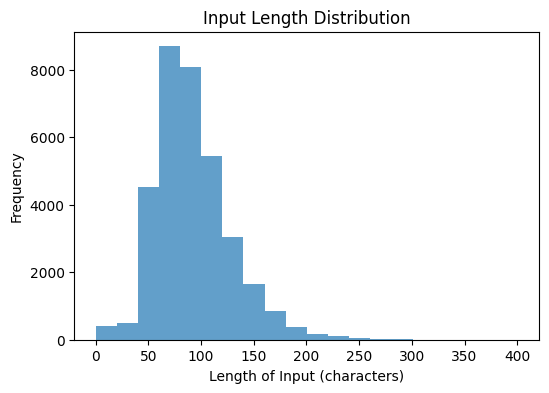

In [38]:
df_copy = df
df_copy['input'].apply(len).plot(kind='hist', bins=20, figsize=(6, 4), title='Input Length Distribution', alpha=0.7)
plt.xlabel('Length of Input (characters)')
plt.ylabel('Frequency')
plt.show()



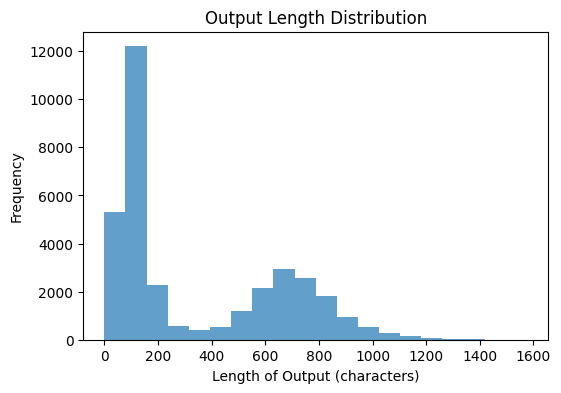

In [39]:
df_copy = df
df_copy['output'].apply(len).plot(kind='hist', bins=20, figsize=(6, 4), title='Output Length Distribution', alpha=0.7)
plt.xlabel('Length of Output (characters)')
plt.ylabel('Frequency')
plt.show()

As we can see, for "Input", most of the questions stays between 70-100 charcahters of length. For what concerns "Output", the answers, we can see majority of them is within a really the range 100-200. As you can also notice, questions contain more carachters than answers.

Below, I see if there is any correlation between length of the question and lentgh of the answer.

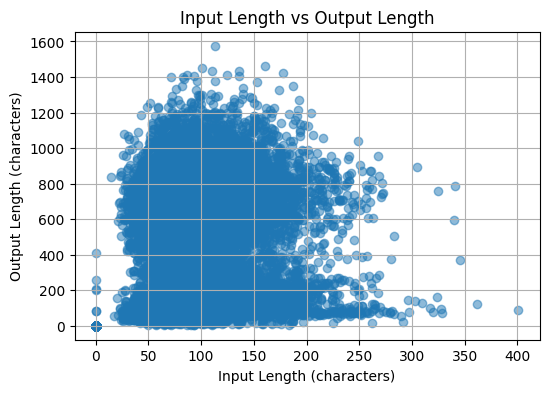

In [40]:
plt.figure(figsize=(6, 4))
plt.scatter(df_copy['input'].apply(len), df_copy['output'].apply(len), alpha=0.5)
plt.title('Input Length vs Output Length')
plt.xlabel('Input Length (characters)')
plt.ylabel('Output Length (characters)')
plt.grid(True)
plt.show()

The scatter plot does not suggest any correlation between lenght opf question and length of answer.

Below I check if there are any duplicates.

In [41]:
print("Total Number of Duplicates:", df[['input', 'output']].duplicated().sum())

Total Number of Duplicates: 427


Here we can see how many unique flashcardscards have at least one duplicate

In [42]:
# Group by 'input' and 'output' and count occurrences
duplicate_counts = df.copy()
duplicate_counts = duplicate_counts.groupby(['input', 'output']).size().reset_index(name='count')

# Filter out flashcards that are duplicated (count > 1)
duplicated_flashcards = duplicate_counts[duplicate_counts['count'] > 1].copy()

# Count how many distinct flashcards are duplicated
num_distinct_duplicates = len(duplicated_flashcards)

print(num_distinct_duplicates)

27


Here we can see how much duoplicates each unique card has. 1 means that it has 1 duplicate.

In [43]:
duplicated_flashcards['duplicates'] = duplicated_flashcards['count'] - 1  # Subtract 1 to get the number of duplicates
duplicated_flashcards[['input', 'output', 'duplicates']]

input  \
0                                                          
1797   How can normal levels of angiotensin II impact...   
3076   How is polycythemia vera characterized in term...   
3391   How would you describe the relationship betwee...   
4279   In hemodynamically stable patients with normal...   
6633   What are lymphoblasts, and what is the signifi...   
6855   What are some common clinical features seen in...   
7548   What are some potential complications of inade...   
9643   What are the risks associated with poorly cont...   
10973  What causes renal pelvis and ureter dilation d...   
11635  What could be the possible diagnosis for an el...   
11873  What does a UTI with sterile pyuria suggest an...   
12031  What does the presence of casts in the urine i...   
13113  What is Hemolytic uremic syndrome and what is ...   
13859  What is a complication that may occur 3-5 days...   
15688  What is one clinical feature of aortic regurgi...   
18543  What is the effect of pregnancy on glomerular ...   
21538  What is the name of the ligament that connects...   
21924  What is the name of the surgical emergency tha...   
25880  What is the term for the type of amnesia that ...   
26346  What is the type of vaccine used for the MMR (...   
26624  What is the typical presentation of patients w...   
26955      What is urge incontinence and what causes it?   
28278  What treatment should be given to patients in ...   
29001  What type of immune response does the Strep pn...   
30148  Where does osteosarcoma typically arise in lon...   
32839  Which type of CNS tumors are commonly associat...   

                                                  output  duplicates  
0                                                                401  
1797   Normal levels of angiotensin II can cause an i...           1  
3076   Polycythemia vera is a blood disorder that is ...           1  
3391   Patients with obsessive-compulsive personality...           1  
4279   CT angiography is considered the preferred dia...           1  
6633   Lymphoblasts are immature lymphocytes. Positiv...           1  
6855   Patients with anorexia nervosa commonly presen...           1  
7548   Complications of inadequate weight gain during...           1  
9643   All forms of poorly controlled maternal diabet...           1  
10973  Renal pelvis and ureter dilation during pregna...           1  
11635  The likely diagnosis for the patient's conditi...           1  
11873  A UTI with sterile pyuria suggests urethritis,...           1  
12031  The presence of casts in the urine indicates t...           1  
13113  Hemolytic uremic syndrome is a condition that ...           1  
13859  A complication that may occur 3-5 days after a...           1  
15688  One clinical feature of aortic regurgitation i...           1  
18543  Pregnancy typically leads to an increase in gl...           1  
21538  The ligament that connects the cervix to the s...           1  
21924  Midgut volvulus is a surgical emergency that c...           1  
25880  Dissociative amnesia is the term for the type ...           1  
26346  The type of vaccine used for the MMR virus is ...           1  
26624  Patients with hairy cell leukemia typically pr...           1  
26955  Urge incontinence is a type of incontinence th...           1  
28278  Patients in preterm labor at less than 37 week...           1  
29001  The Strep pneumoniae conjugate vaccine produce...           1  
30148  Osteosarcoma typically arises in the metaphysi...           1  
32839  Meningiomas are commonly associated with neuro...           1

What we can see is that a lot of duplicates are for an empty row, i.e. there are 401 empty rows duplicates. Let's confirm that:

In [44]:
empty_text_rows = (df[['input', 'output']].isnull().all(axis=1)) | ((df[['input', 'output']] == "").all(axis=1))

# Count the rows with empty text
empty_text_rows.sum()

402

This means that 402 entries contain a question AND an answer which are empty (more specifically with an empty text).

Thus, if we remove from the dataset such cases and the remaining 26 duplicates, we are left with:

In [45]:
df = df.drop_duplicates(subset=['input', 'output'])
print(len(df), "entries")

33528 entries


But since we have still the empty row and we may have NA values around, let's clean further the dataset. 

In [46]:
df= df.replace("", pd.NA).dropna(subset=['input', 'output'])
print(len(df), "entries")

33521 entries


**Now, let's tokenize to do further content analysis.** I am not going to use the same tokenizer used for the model, since for this analysis I need more flexibility and the llama model tokenizer is not easily customizable and not so suited for this kind of quick analysis.For this reason I use scispacy, which is a variation of the very light and customizable spacy tokenizer, which was fine-tuned on medical language.

At first, let's define two functions for sentence cleaning and tokenization

In [47]:
#This removes non-word carachters (exept "-" and single quote ) and normalizes spaces
def preprocess_text(text, allowed_characters="-'"):
    allowed_characters = re.escape(allowed_characters)
    cleaned_text = re.sub(rf"[^\w{allowed_characters}\s]", '', text)  # Keep `-` and `'`
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Normalize spaces
    return cleaned_text

# This tokenizes a cleaned sentence using spacy
def tokenize_text(text):
    processed_text = preprocess_text(text)
    tokens = [token.text.lower() for token in nlp(processed_text)]
    return tokens

#This creates a list containing all tokens, a list of tokenized (question, answer) pairs and
#returns tokenized input_tokens and output which will later be included in the dataframe
def tokenize_and_collect(row):
    global all_tokens, all_tokenized_sentences
    input_tokens = [token.text.lower() for token in nlp(preprocess_text(row['input']))]
    output_tokens = [token.text.lower() for token in nlp(preprocess_text(row['output']))]
    all_tokens.extend(input_tokens)
    all_tokens.extend(output_tokens)
    all_tokenized_sentences.append((input_tokens, output_tokens))
    return input_tokens, output_tokens

In [49]:
# pickle files PATHS 
all_tokens_file = f"{DATA_ANALISYS}/all_tokens.pkl"
all_tokenized_sentences_file = f"{DATA_ANALISYS}/all_tokenized_sentences.pkl"
tkn_df_file = f"{DATA_ANALISYS}/kn_df.pkl"

# Check if pickle files exist
files_exist = (
    os.path.exists(all_tokens_file) and
    os.path.exists(all_tokenized_sentences_file) and
    os.path.exists(tkn_df_file)
)

if files_exist:
    print("Loading existing pickle files...")
    with open(all_tokens_file, 'rb') as f:
        all_tokens = pickle.load(f)
    with open(all_tokenized_sentences_file, 'rb') as f:
        all_tokenized_sentences = pickle.load(f)
    with open(tkn_df_file, 'rb') as f:
        tkn_df = pickle.load(f)
    print("Pickle files loaded.")
else:
    # Files do not exist, process the data
    print("Pickle files not found. Running Tokenization (this will take a wile)...")

    # Load SpaCy model and enable tqdm for pandas
    nlp = spacy.load("en_core_sci_sm")
    tqdm.pandas()

    # Initialize arrays and dataframe
    all_tokens = []
    all_tokenized_sentences = []

    # Assume `df` is already loaded with your data
    tkn_df = df.copy()

    # Process the dataframe
    tkn_df['input_tknd'], tkn_df['output_tknd'] = zip(*tkn_df.progress_apply(tokenize_and_collect, axis=1))

    print("Tokenization complete. Saving variables in pickle files")
    # Ensure the output directory exists
    if not os.path.exists(DATA_ANALISYS):
        print("No data_analysis directory, please provide one and stor its path in DATA_ANALISYS (in config cell)")

    # Save the results
    with open(all_tokens_file, 'wb') as f:
        pickle.dump(all_tokens, f)
    with open(all_tokenized_sentences_file, 'wb') as f:
        pickle.dump(all_tokenized_sentences, f)
    with open(tkn_df_file, 'wb') as f:
        pickle.dump(tkn_df, f)

    print("Data processing complete and files saved.")


Loading existing pickle files...
Pickle files loaded.


At first, I do a quick check on the quality of the tokenization, by looking at how the first five questions have been tokenized

In [50]:


pd.set_option('display.max_colwidth', None)
tkn_df[['input', 'input_tknd']].iloc[50:60]

input  \
50                                            What is β-thalassemia intermedia and what is the cause of moderate anemia associated with it?   
51  What is the result of β-thalassemia mutations in β-globin genes and how do these mutations affect the production of the β-globin chain?   
52                                 What is the impact of β-thalassemia mutations on the production of the β-globin chain in β-globin genes?   
53                                                                What is anisopoikilocytosis and how is it related to β-thalassemia major?   
54                                                   What is the association between β-thalassemia major and nucleated RBCs on blood smear?   
55                                                       What is extramedullary hematopoiesis and how is it related to β-thalassemia major?   
56                                                                     What are the common genetic mutations associated with β-thalassemia?   
57                                                                            What are some common mutations associated with β-thalassemia?   
58                                                                                In which populations is β-thalassemia most commonly seen?   
59                                                                           Which populations are most commonly affected by β-thalassemia?   

                                                                                                                                                       input_tknd  
50                                                   [what, is, β-thalassemia, intermedia, and, what, is, the, cause, of, moderate, anemia, associated, with, it]  
51  [what, is, the, result, of, β-thalassemia, mutations, in, β-globin, genes, and, how, do, these, mutations, affect, the, production, of, the, β-globin, chain]  
52                                      [what, is, the, impact, of, β-thalassemia, mutations, on, the, production, of, the, β-globin, chain, in, β-globin, genes]  
53                                                                           [what, is, anisopoikilocytosis, and, how, is, it, related, to, β-thalassemia, major]  
54                                                            [what, is, the, association, between, β-thalassemia, major, and, nucleated, rbcs, on, blood, smear]  
55                                                                 [what, is, extramedullary, hematopoiesis, and, how, is, it, related, to, β-thalassemia, major]  
56                                                                                  [what, are, the, common, genetic, mutations, associated, with, β-thalassemia]  
57                                                                                          [what, are, some, common, mutations, associated, with, β-thalassemia]  
58                                                                                              [in, which, populations, is, β-thalassemia, most, commonly, seen]  
59                                                                                         [which, populations, are, most, commonly, affected, by, β-thalassemia]

As we can see above, by not removing the "-" carachter, we get a way better and context aware tokenization: instead of dividing "β-thalassemia" in [β, thalassemia], the tokenizer keeps it as it should be.

In [51]:
print("Top 10 Most Frequent Words:")
print(Counter(all_tokens).most_common(10))
print("Total tokenized sentences (input, output):", len(all_tokenized_sentences))

Top 10 Most Frequent Words:
[('the', 145790), ('of', 95473), ('is', 82187), ('and', 76093), ('to', 57556), ('a', 52629), ('in', 51969), ('what', 30674), ('that', 28860), ('can', 28006)]
Total tokenized sentences (input, output): 33528


Let's see how the number of words distributes among question and anwers

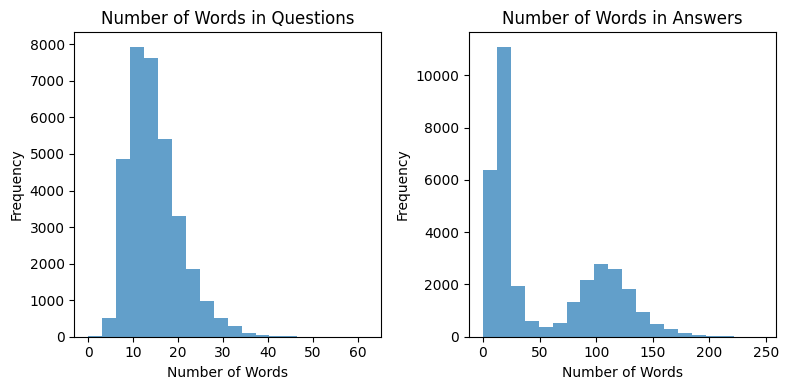

In [52]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
tkn_df['input_tknd'].apply(len).plot(kind='hist', bins=20, alpha=0.7, title='Number of Words in Questions')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
tkn_df['output_tknd'].apply(len).plot(kind='hist', bins=20, alpha=0.7, title='Number of Words in Answers')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The number of words used in questions and in answer reflects the results obtained previously with the carachters: fmost of the questions are composed of 15-20 words, while for answers the distribution is more diverse, and the maximu lenght of word used is higher then for questions.

Let's see if number of words in question correlates with number of words in answer

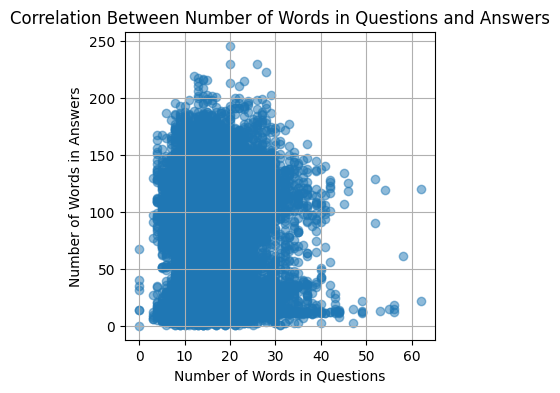

In [53]:
# 3. Correlation/Scatter between number of words in questions and answers
plt.figure(figsize=(4, 4))
plt.scatter(tkn_df['input_tknd'].apply(len), tkn_df['output_tknd'].apply(len), alpha=0.5)
plt.title('Correlation Between Number of Words in Questions and Answers')
plt.xlabel('Number of Words in Questions')
plt.ylabel('Number of Words in Answers')
plt.grid(True)
plt.show()

As for caracthers, no noticeable correlation can be found

Let's analyze the distribution of the frequency of words

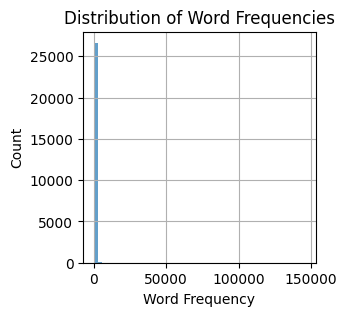

In [54]:
word_frequencies = Counter(all_tokens)
frequency_values = list(word_frequencies.values())

plt.figure(figsize=(3, 3))
plt.hist(frequency_values, bins=50, alpha=0.7)
plt.title('Distribution of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This means that most of the words have a low frequency, let's take a closer look

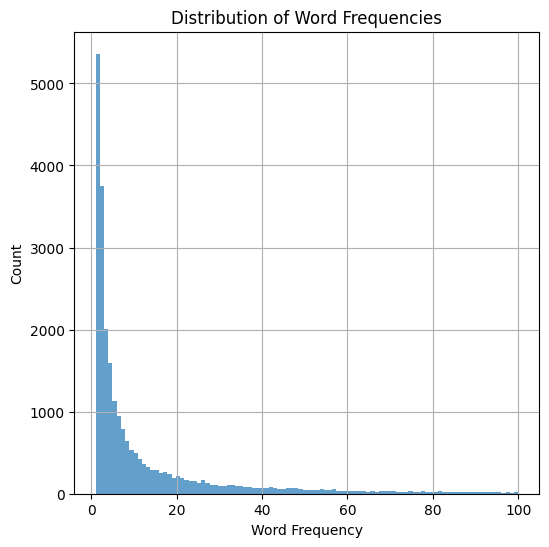

In [55]:
filtered_frequencies = [freq for freq in frequency_values if 1 <= freq <= 100]
plt.figure(figsize=(6, 6))
plt.hist(filtered_frequencies, bins=100, alpha=0.7)
plt.title('Distribution of Word Frequencies')
plt.xlabel('Word Frequency')
plt.ylabel('Count')
plt.grid(True)
plt.show()

We can see that most of thw word has a frequency of 1 or few, as it was expected.

### Words Relations Analysis
Here we create a Word2Vec Istance to analyze relationship within words

Here we create a Word2Vec Model istance and we see how big is the Vocabulary it created and further investigate words semantic relationship as encoded by the embeddings.

In [56]:
from gensim.models.word2vec import Word2Vec
tokenized_sentences = [question + answer for question, answer in all_tokenized_sentences]
model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10) #min_count menas is only going to learn vectors for vocabulary words which frequency is at least 5

In [59]:
print("size of the dictionary:",len(model.wv))

size of the dictionary: 13999


Now let's see what words the model considers to be closer to a term of our choice

In [60]:
term = 'disease'

model.wv.most_similar(term)

[('diseases', 0.650723934173584),
 ('arthritis', 0.6094027757644653),
 ('lupus', 0.5848276615142822),
 ('immune', 0.5608394742012024),
 ('disorders', 0.5599337816238403),
 ('autoimmune', 0.5556820631027222),
 ('transplant', 0.5510331988334656),
 ('transplanted', 0.5499289631843567),
 ('attack', 0.5470234751701355),
 ('alzheimer', 0.5448369979858398)]

In [61]:
term = 'nucleotide'

model.wv.most_similar(term)

[('mrna', 0.9361497759819031),
 ('nucleotides', 0.9355908036231995),
 ('cytosine', 0.9342698454856873),
 ('strand', 0.9241123795509338),
 ('uracil', 0.9030411839485168),
 ('pyrimidine', 0.9028258919715881),
 ('trna', 0.9013506174087524),
 ('molecule', 0.9012126922607422),
 ('rna', 0.9011366367340088),
 ('adenine', 0.9010154008865356)]

Well, everything seems medically reasonable...

Now, let's plot the embedding space and investigate it

In [63]:
#choose a random sample of 100 word embeddings
sample= random.sample(list(model.wv.key_to_index), 100)
word_vectors = model.wv[sample]

#riduce word embedding dimensionailty to 3 dimensions, associated to 3 columns
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

#plot the 100 random word emebeddings labeled
fig = px.scatter_3d(x=x[:100],y=y[:100],z=z[:100],text=sample[:100])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()



So, I have no background about medicine, thus is hard to validate such embeddings correlation, let's try something which even non-doctors could broadly evaluate, i.e. let's plot some deseases and their relationship

In [65]:
diseases = ['pneumonia','sclerosis','cancer', 'hiv', 'stroke', 'tumor','immunosuppressed','death']

word_vectors = model.wv[diseases+sample]
tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)
x, y, z = np.transpose(tsne_embedding)

r = (-250,250)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=diseases + [None] * 100)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.update_layout(autosize=False, width=800, height=800)
fig.show()



Tumor and hiv seems close to death, which could make sense.
Let's see how our model adresses analogies

In [66]:
# Words for analogy
A = 'rare'
B = 'disease'
C = 'cancer'

# Calculate the vector: vec(A) - vec(B) + vec(C)
vec = model.wv[A] - model.wv[B] + model.wv[C]

# Find the most similar words to the resulting vector
similar_words = model.wv.similar_by_vector(vec, topn=5)  #B is to A as C is to ...
print("Words similar to the analogy:", similar_words)

Words similar to the analogy: [('choriocarcinoma', 0.6806141138076782), ('cancerous', 0.6321420073509216), ('malignant', 0.6197514533996582), ('teratomas', 0.6133576035499573), ('anaplasia', 0.595980703830719)]


I discovered that "chorioarcinoma" is a rare form of uteral cancer. So the analogy seems to work.

## Examples

### RAG and LLM Interaction

Example of Interaction with the Chroma Database

1. Random Query: we take one question from the database and we query it. We are returned with the most 3 semantically related documents (i.e. answers)

In [68]:
# Get a random query from the dataset
random_no = random.randint(0, len(dataset) - 1)
query = f"{dataset[random_no]['input']}"

# Query the database with the given question ( get k most similar documents )
results = query_database(query, database)

print(f"Question: {query}\n")

#printing results (i.e. result of chroma db query)
for idx, (document, similarity) in enumerate(results, start=1):
    print(f"{idx}° Best Matching Document: Document # {df[df['input'].str.contains(document.metadata['input'], case=False, na=False)].index[0]}")
    print(f"Similarity: {similarity:.3f}")
    print(f"Question in Document:\n{document.metadata['input']}")
    print(f"Answer in Document:\n{document.metadata['output']}")
    print("-" * 80)

#print(f"Answer: {answer}")
print(f"Expected: {dataset[random_no]['output']}")


Question: Is it common for illness anxiety disorder to present with physical symptoms?

1° Best Matching Document: Document # 28691
Similarity: 0.814
Question in Document:
Is it common for illness anxiety disorder to present with physical symptoms?
Answer in Document:
No, it is not common for illness anxiety disorder to present with physical symptoms. This is a key differentiating feature from somatic symptom disorder, where physical symptoms are present.
--------------------------------------------------------------------------------
2° Best Matching Document: Document # 4351
Similarity: 0.478
Question in Document:
What is the defining feature of anxiety disorders, and how does it affect individuals who experience them?
Answer in Document:
Anxiety disorders are a group of mental health conditions that are characterized by an inappropriate experience of fear or worry, and physical manifestations that are incongruent with the magnitude of the perceived stressor. This means that individu

2. Semantic Querying: we ask a question not explicitly contained in the database to see what 3 best matching documents are returned 

In [25]:
query = 'What are the symptoms of a heart attack?'

results = query_database(query, database)

print(f"Question: {query}\n")

#printing results (i.e. result of chroma db query)
for idx, (document, similarity) in enumerate(results, start=1):
    print(f"{idx}° Best Matching Document: Document # {df[df['input'].str.contains(document.metadata['input'], case=False, na=False)].index[0]}")
    print(f"Similarity: {similarity:.3f}")
    print(f"Question in Document:\n{document.metadata['input']}")
    print(f"Answer in Document:\n{document.metadata['output']}")
    print("-" * 80)

Question: What are the symptoms of a heart attack?

1° Best Matching Document: Document # 22312
Similarity: 0.405
Question in Document:
What are some common characteristics of the chest pain that is associated with myocardial infarction?
Answer in Document:
Chest pain associated with myocardial infarction often presents as severe crushing pain lasting more than 20 minutes that may radiate to the left arm or jaw.
--------------------------------------------------------------------------------
2° Best Matching Document: Document # 27767
Similarity: 0.375
Question in Document:
What medical condition can present with atypical symptoms such as epigastric pain and vomiting?
Answer in Document:
Acute coronary syndrome can present with atypical symptoms such as epigastric pain and vomiting. Acute coronary syndrome is a medical emergency that occurs when there is a sudden blockage of blood flow to the heart, which can lead to a heart attack. While chest pain is a common symptom of acute coronar

Example of Interacting with LLM and RAG

In [29]:
# Get a random query from the dataset
random_no = random.randint(0, len(dataset) - 1)
query = f"{dataset[random_no]['input']}"

# Query the database with the given question ( get k most similar documents )
results = query_database(query, database)

# Generate a prompt for the LLM model using the query and the results from the database.
prompt = generate_rag_sysprompt(results, query)

# Generate answer from the LLM 
answer = query_unsloth(prompt, llmodel, tokenizer)
#answer = query_hf_pipeline(prompt, model_ll3bi, tokenizer_ll3bi)

print(f"Question: {query}\n")
print(f"Answer: {answer}\n")
print(f"Expected: {dataset[random_no]['output']}")

Question: What are the cardiovascular manifestations of lupus?

Prompt: 
You are a precise and context-aware Q/A bot. Given the following documents, separated by lines:

------------------------------
Question: What are the cardiovascular manifestations of lupus?
Answer: The cardiovascular manifestations of lupus include accelerated atherosclerosis, small-vessel necrotizing vasculitis, pericarditis, and libman-sacks endocarditis. Lupus is an autoimmune disease that can affect various organs and tissues in the body, including the heart and blood vessels. Accelerated atherosclerosis, which is the buildup of plaque in the arteries, can increase the risk of heart attack and stroke in people with lupus. Small-vessel necrotizing vasculitis is inflammation and damage to the small blood vessels, which can cause a range of symptoms such as skin rashes, joint pain, and organ damage. Pericarditis is inflammation of the lining around the heart, which can cause chest pain and other symptoms. Libman

### Zero-Shot Example

In [31]:
# Zero-shot

# Get a random query from the dataset
random_no = random.randint(0, len(dataset) - 1)
query = dataset[random_no]['input']

# Generate answer from the LLM 
answer = query_unsloth(query, llmodel, tokenizer)

print(f"Question: {query}\n")
print(f"Answer: {answer}")
print(f"Expected: {dataset[random_no]['output']}")

Question: What is a synthase/synthetase enzyme and what is its function?

Answer: A synthase/synthetase enzyme is a type of enzyme that catalyzes the formation of a new chemical bond between two molecules, resulting in the synthesis of a new compound. This type of enzyme is involved in a wide range of biological processes, including the synthesis of amino acids, nucleotides, and other important molecules. Synthase/synthetase enzymes are typically found in the cytosol of cells and are activated by the presence of specific substrates or cofactors. They
Expected: A synthase/synthetase enzyme is a type of enzyme that joins two molecules together using a source of energy. These enzymes are involved in many biological processes, including the synthesis of DNA, RNA, proteins, and other molecules. They work by catalyzing the formation of a new chemical bond between the two molecules, often using the energy from ATP hydrolysis or another energy source. The specific function of a synthase/synthe

### Few-Shot Example

In [33]:
# Few-Shot Learning

# Get a few examples from the dataset
few_shot_prompt = generate_fewshots_sysprompt(dataset)

# Get random query
random_no = random.randint(0, len(dataset) - 1)
query = dataset[random_no]['input']

# Generate a prompt for the LLM model using the few-shot examples and the query
prompt = f"{few_shot_prompt}\n\nInstruction: Answer the following question\nInput: {query}"

# Generate answer from the LLM 
answer = query_unsloth(query, llmodel, tokenizer)

print(f"Question: {query}\n")
print(f"Answer: {answer}")
print(f"Expected: {dataset[random_no]['output']}")

Question: What is the relationship between heparin-induced thrombocytopenia and platelet count?

Answer: In heparin-induced thrombocytopenia, there is a decrease in platelet count. This is because heparin can activate platelets, leading to their destruction and removal from the bloodstream. As a result, there is a decrease in the number of platelets available to form blood clots, which can increase the risk of bleeding. Therefore, it is important to monitor platelet count in patients who are receiving heparin therapy and to adjust the dose of heparin as
Expected: Heparin-induced thrombocytopenia is a condition in which the immune system produces antibodies against complexes of heparin and a protein called platelet factor 4 (PF4). This can lead to the activation of platelets and the formation of blood clots, which can cause a decrease in the number of platelets in the blood (thrombocytopenia). Therefore, heparin-induced thrombocytopenia is associated with a low platelet count.


## Finetunning
In the following cell, we'll run the finetunning process for each model, we did this one by one, replacing the model name on the previous cells where llm and tokenizer are assigned.

In [24]:
show_mem_stats()
training_stats, llmodel, tokenizer = finetune_model(
    model=llmodel, 
    tokenizer=tokenizer, 
    dataset=dataset, 
    epochs=2, 
    learning_rate=3e-5, 
    max_steps=0) # If max_step is defined, it will override the epochs, else leave 0 and the epochs will be used.

print(training_stats.metrics)

GPU = NVIDIA L4. Max memory = 22.168 GB.
18.246 GB of memory reserved.


Map:   0%|          | 0/33521 [00:00<?, ? examples/s]

Loading model 'unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit' with precision bf16...


Generating train split: 0 examples [00:00, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 2,351 | Num Epochs = 2
O^O/ \_/ \    Batch size per device = 4 | Gradient Accumulation steps = 4
\        /    Total batch size = 16 | Total steps = 294
 "-____-"     Number of trainable parameters = 41,943,040


Fine-tuning completed for unsloth_Meta-Llama-3.1-8B-Instruct-bnb-4bit_finetuned.
Saving model to llm_finetuned_models/unsloth_Meta-Llama-3.1-8B-Instruct-bnb-4bit_finetuned ...
Compressing model folder into a zip file...
Fine-tuning completed.
{'train_runtime': 11810.8657, 'train_samples_per_second': 0.398, 'train_steps_per_second': 0.025, 'total_flos': 4.360442509126533e+17, 'train_loss': 0.6905288217830009, 'epoch': 2.0}


Here we test that we can indeed load the model from a local path, the previous process should also save the model after finetunning.

In [ ]:
# Clean up the memory
del llmodel
del tokenizer

# Try loading the finetuned model
print(f"{LLM_FINTUNED_PATH}/unsloth_mistral-nemo-instruct-2407-bnb-4bit_finetuned")
llmodel, tokenizer = FastLanguageModel.from_pretrained(
    model_name = f"./{LLM_FINTUNED_PATH}/unsloth_llama-3.2-3b-instruct-bnb-4bit_finetuned",
    max_seq_length=LLM_MAX_SEQ_LENGTH,
    load_in_4bit=True)

## Evaluation
Eval between different models: For each model, evaluate with and without finetunning: Zero-shot, Few-shot, RAG, results ( plots )

In [32]:
# Clean up the memory
try:
    del llmodel
    del tokenizer
except:
    pass

# Show current memory stats ( sometimes we got errors when evaluating because the memory is full )
show_mem_stats()

# Models to evaluate ( name or path, downloaded or finetuned )
# if the model is downloaded, the path should be the name of the model
# if the model is finetuned, the path should be the path to the model

models = [
    ("unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit", True),
    ("unsloth/Llama-3.2-3B-Instruct-bnb-4bit", True),
    ("unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", True),
    ("unsloth/mistral-7b-v0.3-bnb-4bit", True),
    ("unsloth/qwen2.5-0.5b-instruct-bnb-4bit", True),
    (f"{LLM_FINTUNED_PATH}/unsloth_llama-3.2-3b-instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_Meta-Llama-3.1-8B-Instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_mistral-nemo-instruct-2407-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_qwen2.5-0.5b-instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_mistral-7b-v0.3-bnb-4bit_finetuned", False),
]

# Results list to store the evaluation results
results = []

# Evaluate each model
for model_name, downloaded in models:
    print(f"Evaluating model {model_name}...")

    if downloaded:
        # Load local model ( local_files_only )
        llmodel, tokenizer = FastLanguageModel.from_pretrained(
            model_name = model_name,
            cache_dir=LLM_DOWNLOAD_PATH,
            max_seq_length=LLM_MAX_SEQ_LENGTH,
            local_files_only=True,
            load_in_4bit=True)
    else: 
        # Load finetuned model
        llmodel, tokenizer = FastLanguageModel.from_pretrained(
            model_name = model_name,
            max_seq_length=LLM_MAX_SEQ_LENGTH,
            local_files_only=True,
            load_in_4bit=True)

    # Evaluate the model with the first 100 elements of the dataset
    average, metrics = evaluate_all(llmodel, tokenizer, dataset, database, embedding_model, no_elements=1000)
    evaluation = {
        "model": model_name,
        "average": average,
        "metrics": metrics}
    print(f"Eval Results for: {model_name}: {average}")
    results.append(evaluation)

    # Name to save the evaluation results
    eval_path = f"{EVAL_RESULTS_PATH}/{model_name}_eval/evaluation.pkl"

    # Ensure the directory for saving evaluation exists
    os.makedirs(os.path.dirname(eval_path), exist_ok=True)

    # Save the evaluation results
    pickle.dump(evaluation, open(eval_path, "wb"))

    # Compress the eval folder into a zip file to be able to download it
    compress_folder(f"{EVAL_RESULTS_PATH}/{model_name}_eval/")

    # Delete the model and tokenizer to free up memory
    del llmodel
    del tokenizer

GPU = NVIDIA L4. Max memory = 22.168 GB.
10.041 GB of memory reserved.
Evaluating model llm_finetuned_models/unsloth_mistral-7b-v0.3-bnb-4bit_finetuned...
==((====))==  Unsloth 2024.12.4: Fast Mistral patching. Transformers:4.47.1.
   \\   /|    GPU: NVIDIA L4. Max memory: 22.168 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Evaluating model unsloth/mistral-7b-v0.3-bnb-4bit on 1000 out of 33955 entires of the database...


Evaluating Dataset:  51%|█████     | 509/1000 [1:18:15<1:05:45,  8.04s/it]/tmp/ipykernel_2137/4078235796.py:37: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'input': 'What is the mnemonic "Microtubules Get Constructed Very Poorly" used for, and what are the drugs associated with each letter?', 'instruction': 'Answer this question truthfully', 'output': 'The mnemonic "Microtubules Get Constructed Very Poorly" is used to remember drugs that act on microtubules. The drugs associated with each letter are: M for Mebendazole (antihelminthic), G for Griseofulvin (antifungal), C for Colchicine (antigout), V for Vincristine/Vinblastine (anticancer), and P for Paclitaxel (anticancer).'}, page_content='Question: What is the mnemonic "Microtubules Get Constructed Very Poorly" used for, and what are the drugs associated with each letter?\nAnswer: The mnemonic "Microtubules Get Constructed Very Poorly" is used to remember drugs that act on microtubules. The drugs a

Eval Results for: llm_finetuned_models/unsloth_mistral-7b-v0.3-bnb-4bit_finetuned: {'zero_shot': {'Exact Match': 0.009, 'Average F1-Score': 0.4454906214802425, 'Average Semantic Similarity': 0.8567540676863864}, 'few_shot': {'Exact Match': 0.005, 'Average F1-Score': 0.43971652146018747, 'Average Semantic Similarity': 0.8085538589239586}, 'rag': {'Exact Match': 0.312, 'Average F1-Score': 0.8653032305405823, 'Average Semantic Similarity': 0.9677927105501294}}


In [8]:
# Load results from the saved files
models = [
    ("unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit", True),
    ("unsloth/Llama-3.2-3B-Instruct-bnb-4bit", True),
    ("unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit", True),
    ("unsloth/mistral-7b-v0.3-bnb-4bit", True),
    ("unsloth/qwen2.5-0.5b-instruct-bnb-4bit", True),
    (f"{LLM_FINTUNED_PATH}/unsloth_llama-3.2-3b-instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_Meta-Llama-3.1-8B-Instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_mistral-nemo-instruct-2407-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_qwen2.5-0.5b-instruct-bnb-4bit_finetuned", False),
    (f"{LLM_FINTUNED_PATH}/unsloth_mistral-7b-v0.3-bnb-4bit_finetuned", False),
]

results = []

for model_name, downloaded in models:
    eval_path = f"{EVAL_RESULTS_PATH}/{model_name}_eval/evaluation.pkl"
    evaluation = pickle.load(open(eval_path, "rb"))
    results.append(evaluation)

print(results)

[{'model': 'unsloth/Mistral-Nemo-Instruct-2407', 'average': {'zero_shot': {'Exact Match': 0.0, 'Average F1-Score': 0.009919554442096126, 'Average Semantic Similarity': 0.00636001955694519}, 'few_shot': {'Exact Match': 0.0, 'Average F1-Score': 0.00502664491543754, 'Average Semantic Similarity': -0.0053390733657870445}, 'rag': {'Exact Match': 0.168, 'Average F1-Score': 0.6566718637404678, 'Average Semantic Similarity': 0.7000233943362255}}, 'metrics': {'zero_shot': [{'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': -0.05267246812582016}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': -0.0570722371339798}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': -0.027976136654615402}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': 0.040576014667749405}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': -0.10345817357301712}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similarity': -0.05602629482746124}, {'Exact Match': 0, 'F1-Score': 0, 'Semantic Similar

## Comparing Results
Show plots of the results, choose best model and finetuning for the Pipeline

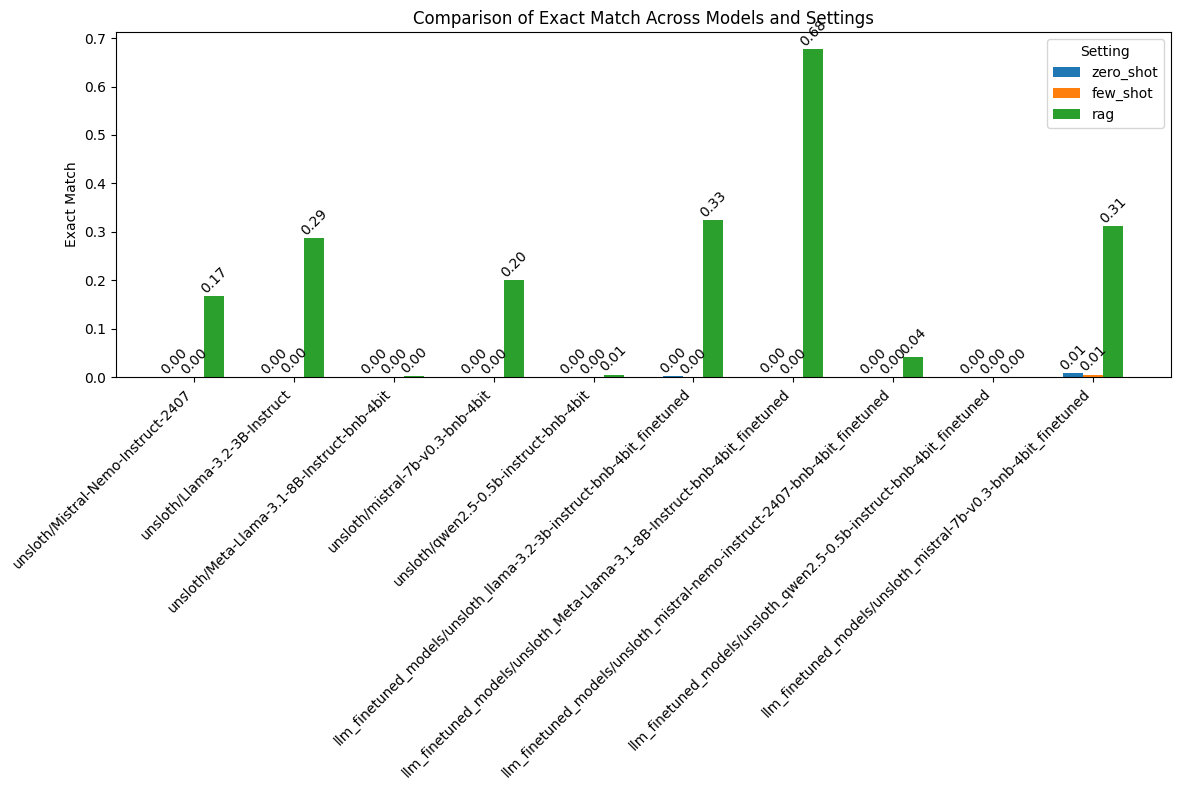

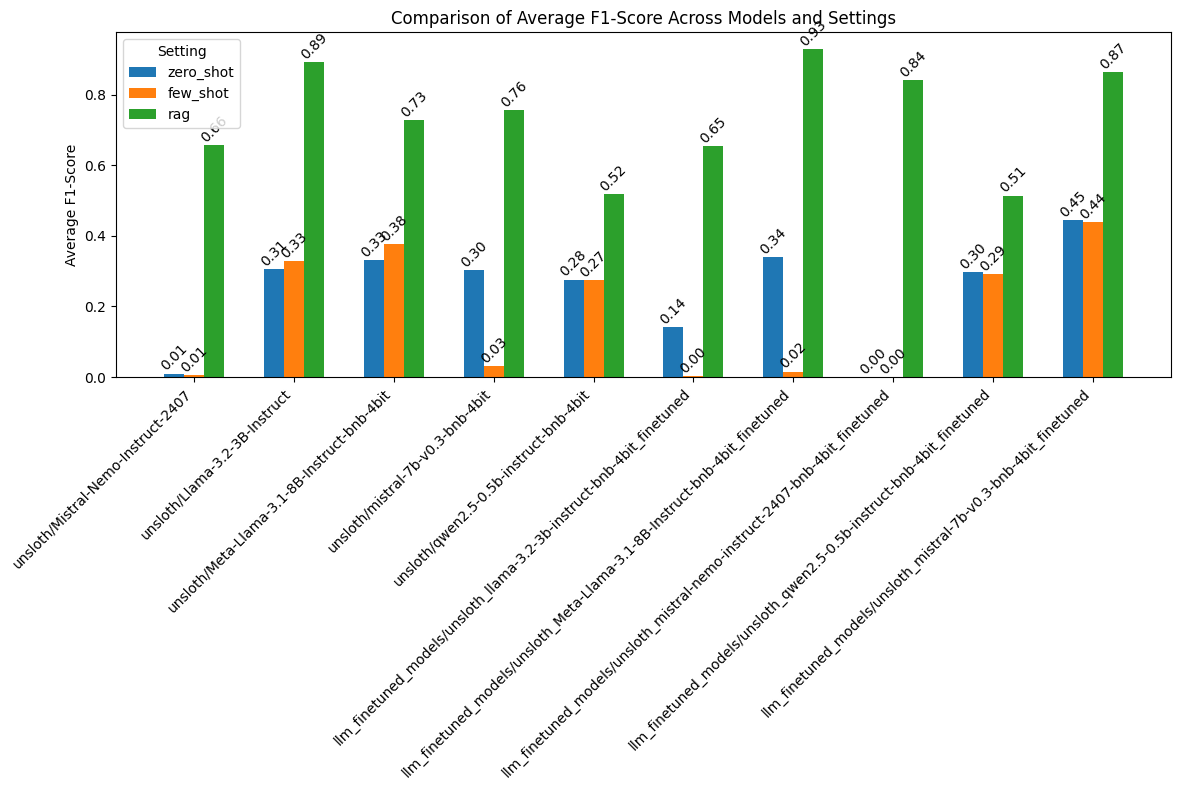

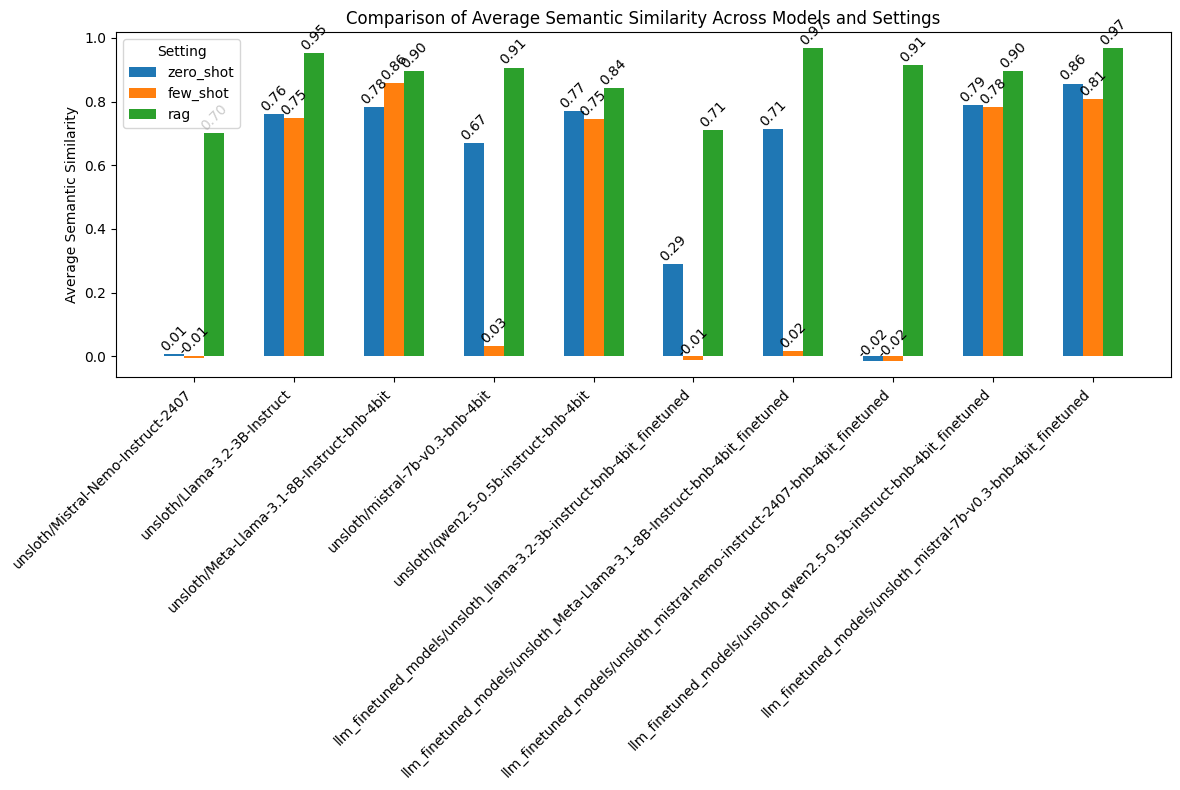

In [11]:
# Yolooooo
plot_model_results(results)

## Pipeline ( Demo )
Audio 2 Text -> LLM -> Text 2 Audio

In [22]:
template = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Audio Recorder</title>
    <!-- Add Bootstrap CSS -->
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f9;
            color: #333;
            margin: 0;
            padding: 0;
            display: flex;
            flex-direction: column;
            align-items: center;
            justify-content: center;
            height: 100vh;
        }
        h1 {
            color: #444;
        }
        .container {
            text-align: center;
            background: #fff;
            border-radius: 8px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            padding: 20px;
            width: 90%;
            max-width: 600px;
        }
        button {
            background-color: #007BFF;
            color: white;
            border: none;
            padding: 10px 20px;
            margin: 10px 5px;
            border-radius: 5px;
            font-size: 16px;
            cursor: pointer;
            transition: background-color 0.3s;
        }
        button:hover {
            background-color: #0056b3;
        }
        button:disabled {
            background-color: #cccccc;
            cursor: not-allowed;
        }
        audio {
            margin-top: 15px;
            width: 100%;
            border-radius: 5px;
        }
        .transcript, .loading-container {
            margin-top: 10px;
            font-size: 14px;
            color: #555;
            text-align: left;
            background: #f9f9f9;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
        }
        .response-container {
            margin-top: 20px;
            text-align: left;
        }
        .response-container h2 {
            color: #555;
        }
        .response-container p {
            background: #f9f9f9;
            padding: 10px;
            border: 1px solid #ddd;
            border-radius: 5px;
        }
        .loading-container {
            display: none;
            text-align: center;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Audio Recorder</h1>
        <button id="record">Start Recording</button>
        <button id="upload" disabled>Upload</button>
        <button id="exit">Shut Down</button>
        
        <!-- Transcript Section -->
        <div id="transcript" class="transcript">
            <h2>Transcript:</h2>
            <p id="transcript-text">No transcript available yet.</p>
            <audio id="audio" controls></audio>
        </div>
        
        <!-- Loading Spinner -->
        <div id="loading" class="loading-container">
            <div class="spinner-border text-primary" role="status">
                <span class="visually-hidden">Loading...</span>
            </div>
            <p>Processing audio...</p>
        </div>
        
        <!-- Response Section -->
        <div class="transcript" id="response-container">
            <h2>Response:</h2>
            <p id="response-text">Waiting for response...</p>
            <audio id="response-audio" controls style="display: none;"></audio>
        </div>
        <hr />
        <div class="transcript"> 
            <h2>RAG:</h2>
             <pre id="rag">awaiting ...</pre>
        </div>
    </div>

    <script>
        let mediaRecorder;
        let audioChunks = [];
        const recordButton = document.getElementById('record');
        const uploadButton = document.getElementById('upload');
        const exitButton = document.getElementById('exit');
        const audioElement = document.getElementById('audio');
        const transcriptText = document.getElementById('transcript-text');
        const responseText = document.getElementById('response-text');
        const responseAudio = document.getElementById('response-audio');
        const loadingSpinner = document.getElementById('loading');
        const rag = document.getElementById('rag');

        function resetInterface() {
            // Reset interface for new recording
            recordButton.disabled = false;
            uploadButton.disabled = true;
            responseAudio.style.display = "none";
            responseAudio.src = "";
            loadingSpinner.style.display = "none";
        }

        recordButton.onclick = async () => {
            if (recordButton.textContent === "Start Recording") {
                const stream = await navigator.mediaDevices.getUserMedia({ audio: true });
                mediaRecorder = new MediaRecorder(stream);
                audioChunks = [];
                mediaRecorder.ondataavailable = (e) => audioChunks.push(e.data);
                mediaRecorder.onstop = () => {
                    const blob = new Blob(audioChunks, { type: 'audio/wav' });
                    const audioURL = URL.createObjectURL(blob);
                    audioElement.src = audioURL;
                    uploadButton.disabled = false;

                    uploadButton.onclick = () => {
                        recordButton.disabled = true;
                        uploadButton.disabled = true;

                        const formData = new FormData();
                        formData.append("audio", blob, "recording.wav");

                        // Show the loading spinner
                        loadingSpinner.style.display = "block";

                        fetch('/process_audio', { method: 'POST', body: formData })
                            .then(response => response.json())
                            .then(data => {
                                // Hide the loading spinner
                                loadingSpinner.style.display = "none";

                                if (data.transcript) {
                                    transcriptText.textContent = data.transcript; // Display the transcript
                                }

                                if (data.text) {
                                    responseText.textContent = data.text; // Display the response
                                }

                                if (data.rag) {
                                    console.log(data.rag);
                                    rag.textContent = data.rag; 
                                }

                                fetch(`/response_audio?token=${data.token}`)
                                    .then(res => res.blob())
                                    .then(blob => {
                                        const url = URL.createObjectURL(blob);
                                        responseAudio.src = url;
                                        responseAudio.style.display = "block";
                                        responseAudio.play();
                                        // Do NOT reset interface to preserve transcript and response
                                        responseAudio.onended = () => {
                                            recordButton.disabled = false;
                                            uploadButton.disabled = true;
                                        };
                                    });
                            })
                            .catch(error => {
                                alert("An error occurred while processing the audio.");
                                console.error(error);
                                loadingSpinner.style.display = "none"; // Hide the loading spinner on error
                                resetInterface();
                            });
                    };
                };
                mediaRecorder.start();
                recordButton.textContent = "Stop Recording";
            } else {
                mediaRecorder.stop();
                recordButton.textContent = "Start Recording";
            }
        };

        exitButton.onclick = () => {
            fetch('/shutdown', { method: 'POST' });
            alert("Server shutting down...");
        };
    </script>
</body>
</html>

"""

s2t2s = ServeS2T2S(llmodel, tokenizer, template, port=65100, server_verbose=True)
s2t2s.serve()

130.211.236.75 - - [13/Jan/2025 20:07:18] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:18] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:21] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:24] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:27] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:31] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:34] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:37] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:40] "GET / HTTP/1.1" 200 -


transcript: what psychiatric condition can beta blockers exacerbate
prompt: 
You are a precise and context-aware Q/A bot. Given the following documents, separated by lines:

------------------------------
Question: What psychiatric condition can beta-blockers exacerbate?
Answer: Depression.
------------------------------
Question: What conditions can β-Blockers treat by blocking hyperadrenergic symptoms?
Answer: β-Blockers can treat conditions such as Thyrotoxicosis (thyroid storm) by blocking the hyperadrenergic symptoms.
------------------------------
Question: In a CAD patient who has attempted suicide, what is the probable cause of bradycardia, AV block, and diffuse wheezing?
Answer: The likely cause of bradycardia, AV block, and diffuse wheezing in a CAD patient who has attempted suicide is β-blocker overdose. β-blockers are commonly used to treat hypertension, angina, and other cardiovascular conditions. However, an overdose of these medications can cause a range of symptoms, inc

130.211.236.75 - - [13/Jan/2025 20:07:44] "POST /process_audio HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:44] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:44] "GET /response_audio?token=1736798863 HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:47] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:50] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:53] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:56] "GET / HTTP/1.1" 200 -
130.211.236.75 - - [13/Jan/2025 20:07:59] "GET / HTTP/1.1" 200 -


transcript: what is the capital of Rome
prompt: Answer in 20 words: what is the capital of Rome


/tmp/ipykernel_56601/4078235796.py:37: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'input': 'What is the name of the center in the cerebral cortex that regulates the pontine and sacral micturition centers?', 'instruction': 'Answer this question truthfully', 'output': 'The medial frontal micturition center in the cerebral cortex regulates the pontine and sacral micturition centers.'}, page_content='Question: What is the name of the center in the cerebral cortex that regulates the pontine and sacral micturition centers?\nAnswer: The medial frontal micturition center in the cerebral cortex regulates the pontine and sacral micturition centers.'), -0.005387024474997393), (Document(metadata={'input': 'What is the structure that receives drainage from the major and minor calyces of the kidney, and what is its relationship to the ureter?', 'instruction': 'Answer this question truthfully', 'output': 'The structure that receives drainage from the major and min

Server has shut down.
